In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# these two modules are homemade
os.chdir('..')
import gtfs
import ttools
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')

## 1. Load schedule data and stop time estimations
Trip and stop metadata is not required.

In [3]:
stop_times, tz_sched = gtfs.load_stop_times('2015-12-03','gtfs/')
interpolated = pd.read_csv('2015-12-03_interpolated.csv')
interpolated = interpolated.merge(stop_times[['arrival_time','stop_sequence']],how='left',left_on=['trip_id','stop_id'],right_index=True)
del stop_times, tz_sched # to free up memory
interpolated.set_index(['route','trip_id','trip_date','vehicle_id','stop_sequence','stop_id'],inplace=True)
print 'Finished loading GTFS data and interpolated stop times and merging.'

Finished loading GTFS data and interpolated stop times and merging.


Convert times to numeric.

In [4]:
interpolated['interpolated_arrival_time'] = pd.to_timedelta(interpolated['interpolated_arrival_time'])
interpolated['arrival_time'] = pd.to_timedelta(interpolated['arrival_time'])

## 2. Create a dataframe containing information about the first and last stop
Because we don't have interpolated data for all stops on each trip, the comparison must be made using travel times only between the first and last stop actually reported.
1. Interpolated arrival time
2. Scheduled arrival time
3. Stop ID

In [5]:
grouped = interpolated.groupby(level=(0,1,2,3))
begins = grouped.min()
ends = grouped.max()
travel_times = begins.join(ends,lsuffix='_begin',rsuffix='_end')
def earliest_stop(g):
    return g.idxmin()[-1][-1]
def latest_stop(g):
    return g.idxmax()[-1][-1]
travel_times['earliest_stop'] = grouped.apply(earliest_stop)
travel_times['latest_stop'] = grouped.apply(latest_stop)

Add calculated columns for travel times (schedule and actual) and also the difference between the two.

In [6]:
travel_times['ttime_schedule'] = (travel_times['arrival_time_end'] - travel_times['arrival_time_begin'])/ttools.datetime.timedelta(seconds=1)
travel_times['ttime_actual'] = (travel_times['interpolated_arrival_time_end'] - travel_times['interpolated_arrival_time_begin'])/ttools.datetime.timedelta(seconds=1)
travel_times['ttime_var'] = travel_times['ttime_actual'] - travel_times['ttime_schedule'] 
# show final dataframe of prepared data
travel_times.head(25)

interpolated_arrival_time_begin  \
route       trip_id                          trip_date  vehicle_id                                       
MTA NYCT_B1 FB_D5-Weekday-SDon-047200_B49_15 2015-12-03 MTA NYCT_5125                  07:59:41.135254   
            FB_D5-Weekday-SDon-051000_B49_15 2015-12-03 MTA NYCT_5125                  08:38:10.052661   
                                                        MTA NYCT_7146                  08:34:55.948902   
            FB_D5-Weekday-SDon-051200_B49_21 2015-12-03 MTA NYCT_7146                  08:52:58.791890   
            UP_D5-Weekday-SDon-006000_B1_1   2015-12-03 MTA NYCT_4877                  01:00:24.142637   
            UP_D5-Weekday-SDon-009800_B1_1   2015-12-03 MTA NYCT_4877                  01:39:31.030136   
            UP_D5-Weekday-SDon-010000_B1_2   2015-12-03 MTA NYCT_4893                         01:35:01   
            UP_D5-Weekday-SDon-013800_B1_2   2015-12-03 MTA NYCT_4893                  02:22:01.246789   
            UP_D5-Weekday-SDon-014000_B1_1   2015-12-03 MTA NYCT_4877                  02:21:18.049751   
            UP_D5-Weekday-SDon-017800_B1_1   2015-12-03 MTA NYCT_4877                  03:00:40.205909   
            UP_D5-Weekday-SDon-018000_B1_2   2015-12-03 MTA NYCT_4893                  03:03:15.603218   
            UP_D5-Weekday-SDon-021800_B1_2   2015-12-03 MTA NYCT_4893                  03:39:45.410219   
            UP_D5-Weekday-SDon-022000_B1_1   2015-12-03 MTA NYCT_4877                  03:40:33.158686   
            UP_D5-Weekday-SDon-025500_B1_3   2015-12-03 MTA NYCT_4990                  04:19:43.447621   
            UP_D5-Weekday-SDon-025800_B1_1   2015-12-03 MTA NYCT_4877                  04:18:40.873124   
                                                        MTA NYCT_7179                  04:35:48.889077   
            UP_D5-Weekday-SDon-028000_B1_4   2015-12-03 MTA NYCT_7179                  04:42:47.464372   
            UP_D5-Weekday-SDon-029400_B1_3   2015-12-03 MTA NYCT_4990                  04:57:58.666312   
                                                        MTA NYCT_7174                  05:21:49.711711   
            UP_D5-Weekday-SDon-030500_B1_5   2015-12-03 MTA NYCT_7191                  05:05:17.022682   
            UP_D5-Weekday-SDon-032400_B1_6   2015-12-03 MTA NYCT_5088                  05:23:49.746965   
            UP_D5-Weekday-SDon-033000_B1_7   2015-12-03 MTA NYCT_7174                  05:30:43.706836   
            UP_D5-Weekday-SDon-034500_B1_3   2015-12-03 MTA NYCT_4990                  05:45:19.865832   
            UP_D5-Weekday-SDon-035100_B1_5   2015-12-03 MTA NYCT_7191                  05:50:44.498051   
            UP_D5-Weekday-SDon-036000_B1_2   2015-12-03 MTA NYCT_4893                  06:04:19.382799   

                                                                       arrival_time_begin  \
route       trip_id                          trip_date  vehicle_id                          
MTA NYCT_B1 FB_D5-Weekday-SDon-047200_B49_15 2015-12-03 MTA NYCT_5125            07:55:25   
            FB_D5-Weekday-SDon-051000_B49_15 2015-12-03 MTA NYCT_5125            08:32:58   
                                                        MTA NYCT_7146            08:35:01   
            FB_D5-Weekday-SDon-051200_B49_21 2015-12-03 MTA NYCT_7146            08:52:16   
            UP_D5-Weekday-SDon-006000_B1_1   2015-12-03 MTA NYCT_4877            01:00:38   
            UP_D5-Weekday-SDon-009800_B1_1   2015-12-03 MTA NYCT_4877            01:38:42   
            UP_D5-Weekday-SDon-010000_B1_2   2015-12-03 MTA NYCT_4893            01:42:53   
            UP_D5-Weekday-SDon-013800_B1_2   2015-12-03 MTA NYCT_4893            02:18:42   
            UP_D5-Weekday-SDon-014000_B1_1   2015-12-03 MTA NYCT_4877            02:20:38   
            UP_D5-Weekday-SDon-017800_B1_1   2015-12-03 MTA NYCT_4877            02:58:42   
            UP_D5-Weekday-SDon-018000_B1_2   2015-12-03 MTA NYCT_4893            03:00:38   

## 3. Show distribution of travel time variance across all trips (or fragments) in data.

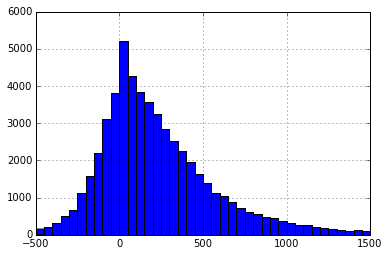

In [7]:
travel_times['ttime_var'].hist(range=(-500,1500),bins=40)

## 4. Compare distributions of travel times for the pairing of stops on each route with the most data
First get the pair of stop IDs on each route that have the most number of estimations.

In [8]:
sample_sizes = travel_times.reset_index().groupby(['route','earliest_stop','latest_stop']).size()
sample_sizes.groupby(level=0).idxmax()

route
MTA NYCT_B1        (MTA NYCT_B1, 300002, 305460)
MTA NYCT_B11      (MTA NYCT_B11, 307485, 306468)
MTA NYCT_B12      (MTA NYCT_B12, 301310, 301343)
MTA NYCT_B13      (MTA NYCT_B13, 301880, 801167)
MTA NYCT_B14      (MTA NYCT_B14, 301516, 307896)
MTA NYCT_B15      (MTA NYCT_B15, 503996, 301092)
MTA NYCT_B16      (MTA NYCT_B16, 301603, 307646)
MTA NYCT_B17      (MTA NYCT_B17, 307027, 301804)
MTA NYCT_B2        (MTA NYCT_B2, 300138, 307636)
MTA NYCT_B20      (MTA NYCT_B20, 503454, 307896)
MTA NYCT_B24      (MTA NYCT_B24, 302255, 302310)
MTA NYCT_B25      (MTA NYCT_B25, 307238, 302440)
MTA NYCT_B26      (MTA NYCT_B26, 307699, 801052)
MTA NYCT_B3        (MTA NYCT_B3, 300185, 300228)
MTA NYCT_B31      (MTA NYCT_B31, 302599, 300182)
MTA NYCT_B32      (MTA NYCT_B32, 551925, 306461)
MTA NYCT_B35      (MTA NYCT_B35, 302678, 307993)
MTA NYCT_B36      (MTA NYCT_B36, 308361, 302868)
MTA NYCT_B37      (MTA NYCT_B37, 301722, 901484)
MTA NYCT_B38      (MTA NYCT_B38, 307460, 503884)
MTA NYCT_B39  

Pick an example, slice the data, and plot the two distributions.

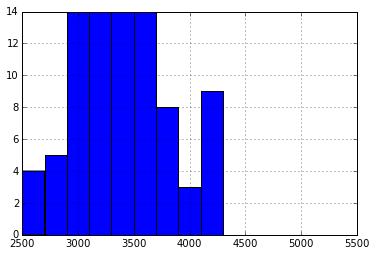

In [9]:
travel_times.loc['MTA NYCT_B41'].query('earliest_stop == 307460 & latest_stop == 307636')['ttime_schedule'].hist(range=(2500,5500),bins=15)

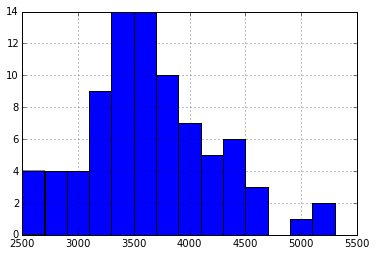

In [10]:
travel_times.loc['MTA NYCT_B41'].query('earliest_stop == 307460 & latest_stop == 307636')['ttime_actual'].hist(range=(2500,5500),bins=15)